In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import regularizers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import set_random_seed
from numpy.random import seed

from pandas_datareader import data as web

import datetime as dt
from IPython.display import display, HTML

Using TensorFlow backend.


In [3]:
#set seeds
seed(1)
set_random_seed(2)

## Retrieve Data through Web Scraping

In [7]:
# web scrap from 1/1/2016 to the most recent day for every stock
stockNames = ['AAPL', 'TXN', 'QCOM', 'INTC', 'GOOG', 'AVGO', 'DUK']

def get_stock(stock, start, end):
    return web.get_data_yahoo(stock, start, end)['Close']

stocks = []

#first stock is the target stock
for stock in stockNames:
    stocks.append(DataFrame(get_stock(stock, dt.datetime(2016, 1, 1), dt.datetime(2017, 11, 5))))

## Data Pre-Processing
We did a windowing since this a time series analysis and windowing can improve the outcome of the model training.

In [8]:
#size of window
num_lags = 1
#keep scalers to rescale back later
scalers = list()
#colnames to update df after windowing
colNames = list()

df = DataFrame()

for i in range(0, len(stocks)):
    # get difference between day 0 closing and day -1 closing
    stock = stocks[i] - stocks[i].shift()
    stock = stock.iloc[1:,:]
    
    #define scale to scale by
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(stock)
    scalers.append(scaler)
    
    if i == 0:
        #add the difference of target stock without lags
        df = concat([df, DataFrame(scaler.transform(stock))], axis = 1)
        colNames.append(stockNames[i]+"_0")
    
    for lag in range(1, num_lags+1):
        #windowing of size num_lags
        tmp = stock.shift(lag)
        tmp.fillna(0, inplace=True)
        tmp = DataFrame(scaler.transform(tmp))
        df = concat([df, tmp], axis = 1)
        colNames.append(stockNames[i]+"_"+str(lag))
        
#add correct names
df.columns = colNames
#add date index 
df.index = stocks[0].index[1:]

df.tail()

,AAPL_0,AAPL_1,TXN_1,QCOM_1,INTC_1,GOOG_1,AVGO_1,DUK_1
Date,,,,,,,,
2017-10-30,0.465998,0.748031,0.124004,0.171677,1.000000,1.000000,0.315372,0.395255
2017-10-31,0.272726,0.465998,-0.510809,0.080828,-0.021560,-0.122417,0.264026,0.225298
2017-11-01,-0.367215,0.272726,-0.039817,-0.418838,0.359868,-0.083601,-0.094137,0.241105
2017-11-02,0.115247,-0.367215,-0.260524,0.396126,0.393033,0.130684,-0.556893,-0.015809
2017-11-03,0.569076,0.115247,-0.083048,0.253173,0.117744,-0.070971,-0.250714,0.438733


In [9]:
#define training and test size
training_size = int(len(df) * 0.7)

#split into training and test sets
training_set, test_set = df.iloc[:training_size, :], df.iloc[training_size:, :]    
#split each set into predictors and label
training_input, training_output = training_set.iloc[:, 1:].values, training_set.iloc[:, :1].values
test_input, test_output = test_set.iloc[:, 1:].values, test_set.iloc[:, :1].values
# add extra row into test_input to predict tomorrow's price
test_input = np.concatenate((test_input, test_set.iloc[-1:, :-1].values))
#reshape input of the LSTM to be format [samples, time steps, features]
training_input = training_input.reshape(training_input.shape[0], 1, training_input.shape[1])
test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[1])
#ensure that training_input is a multiple of batch_size
batch_size = 28
training_input_1 = training_input
training_output_1 = training_output
while (len(training_input_1) % batch_size != 0):
    training_input_1 = training_input_1[1:]
    training_output_1 = training_output_1[1:]
    
num_inputs = len(stocks) * num_lags

## Model Architecture and Training

Here we used LSTM from the Keras package as our model. Our activation function is relu and optimiser is Adam optimization. The Adam optimization algorithm update network weights iterative based in training data. This gives it an advantage over the classical stochastic gradient.

In [20]:
#define model
model = Sequential()
model.add(LSTM(8, batch_input_shape=(batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.03)
model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

model.fit(x=training_input_1, y=training_output_1, epochs=500, batch_size=batch_size, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (28, 8)                   512       
_________________________________________________________________
activation_11 (Activation)   (28, 8)                   0         
_________________________________________________________________
dense_11 (Dense)             (28, 1)                   9         
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
308/308 [==============================] - 0s - loss: 0.0828     
Epoch 2/500
308/308 [==============================] - 0s - loss: 0.0481     
Epoch 3/500
308/308 [==============================] - 0s - loss: 0.0442     
Epoch 4/500
308/308 [==============================] - 0s - loss: 0.0373     
Epoch 5/500
308/308 [==============================] - 0s - loss: 0.0371     
Epoch 6/500
308/30

308/308 [==============================] - 0s - loss: 0.0363     
Epoch 198/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 199/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 200/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 201/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 202/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 203/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 204/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 205/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 206/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 207/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 208/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 209/500
308/308 [==============================]

308/308 [==============================] - 0s - loss: 0.0363     
Epoch 400/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 401/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 402/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 403/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 404/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 405/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 406/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 407/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 408/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 409/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 410/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 411/500
308/308 [==============================]

## Training Outcome

In [21]:
#predict outcome using only batch size = 1
new_batch_size = 1
#get weights of trained model
weights = model.get_weights()
#build new model and set weights
new_model = Sequential()
new_model.add(LSTM(8, batch_input_shape=(new_batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, kernel_regularizer=regularizers.l2(0.01)))
new_model.add(Activation('relu'))
new_model.add(Dense(1))
new_model.set_weights(weights)

adam = optimizers.Adam(lr=0.03)
new_model.compile(loss='mean_squared_error', optimizer=adam)

training_predictions = new_model.predict(training_input, batch_size=new_batch_size)
training_predictions = scalers[0].inverse_transform(training_predictions)

for i in range(len(training_input)):
    training_predictions[i][0] += stocks[0].iloc[i:i+1,:].values[0][0]
    
rmse = sqrt(mean_squared_error(stocks[0].iloc[:training_size, :].values, training_predictions))
print('Training RMSE: %.4f' % rmse)

Training RMSE: 0.1519


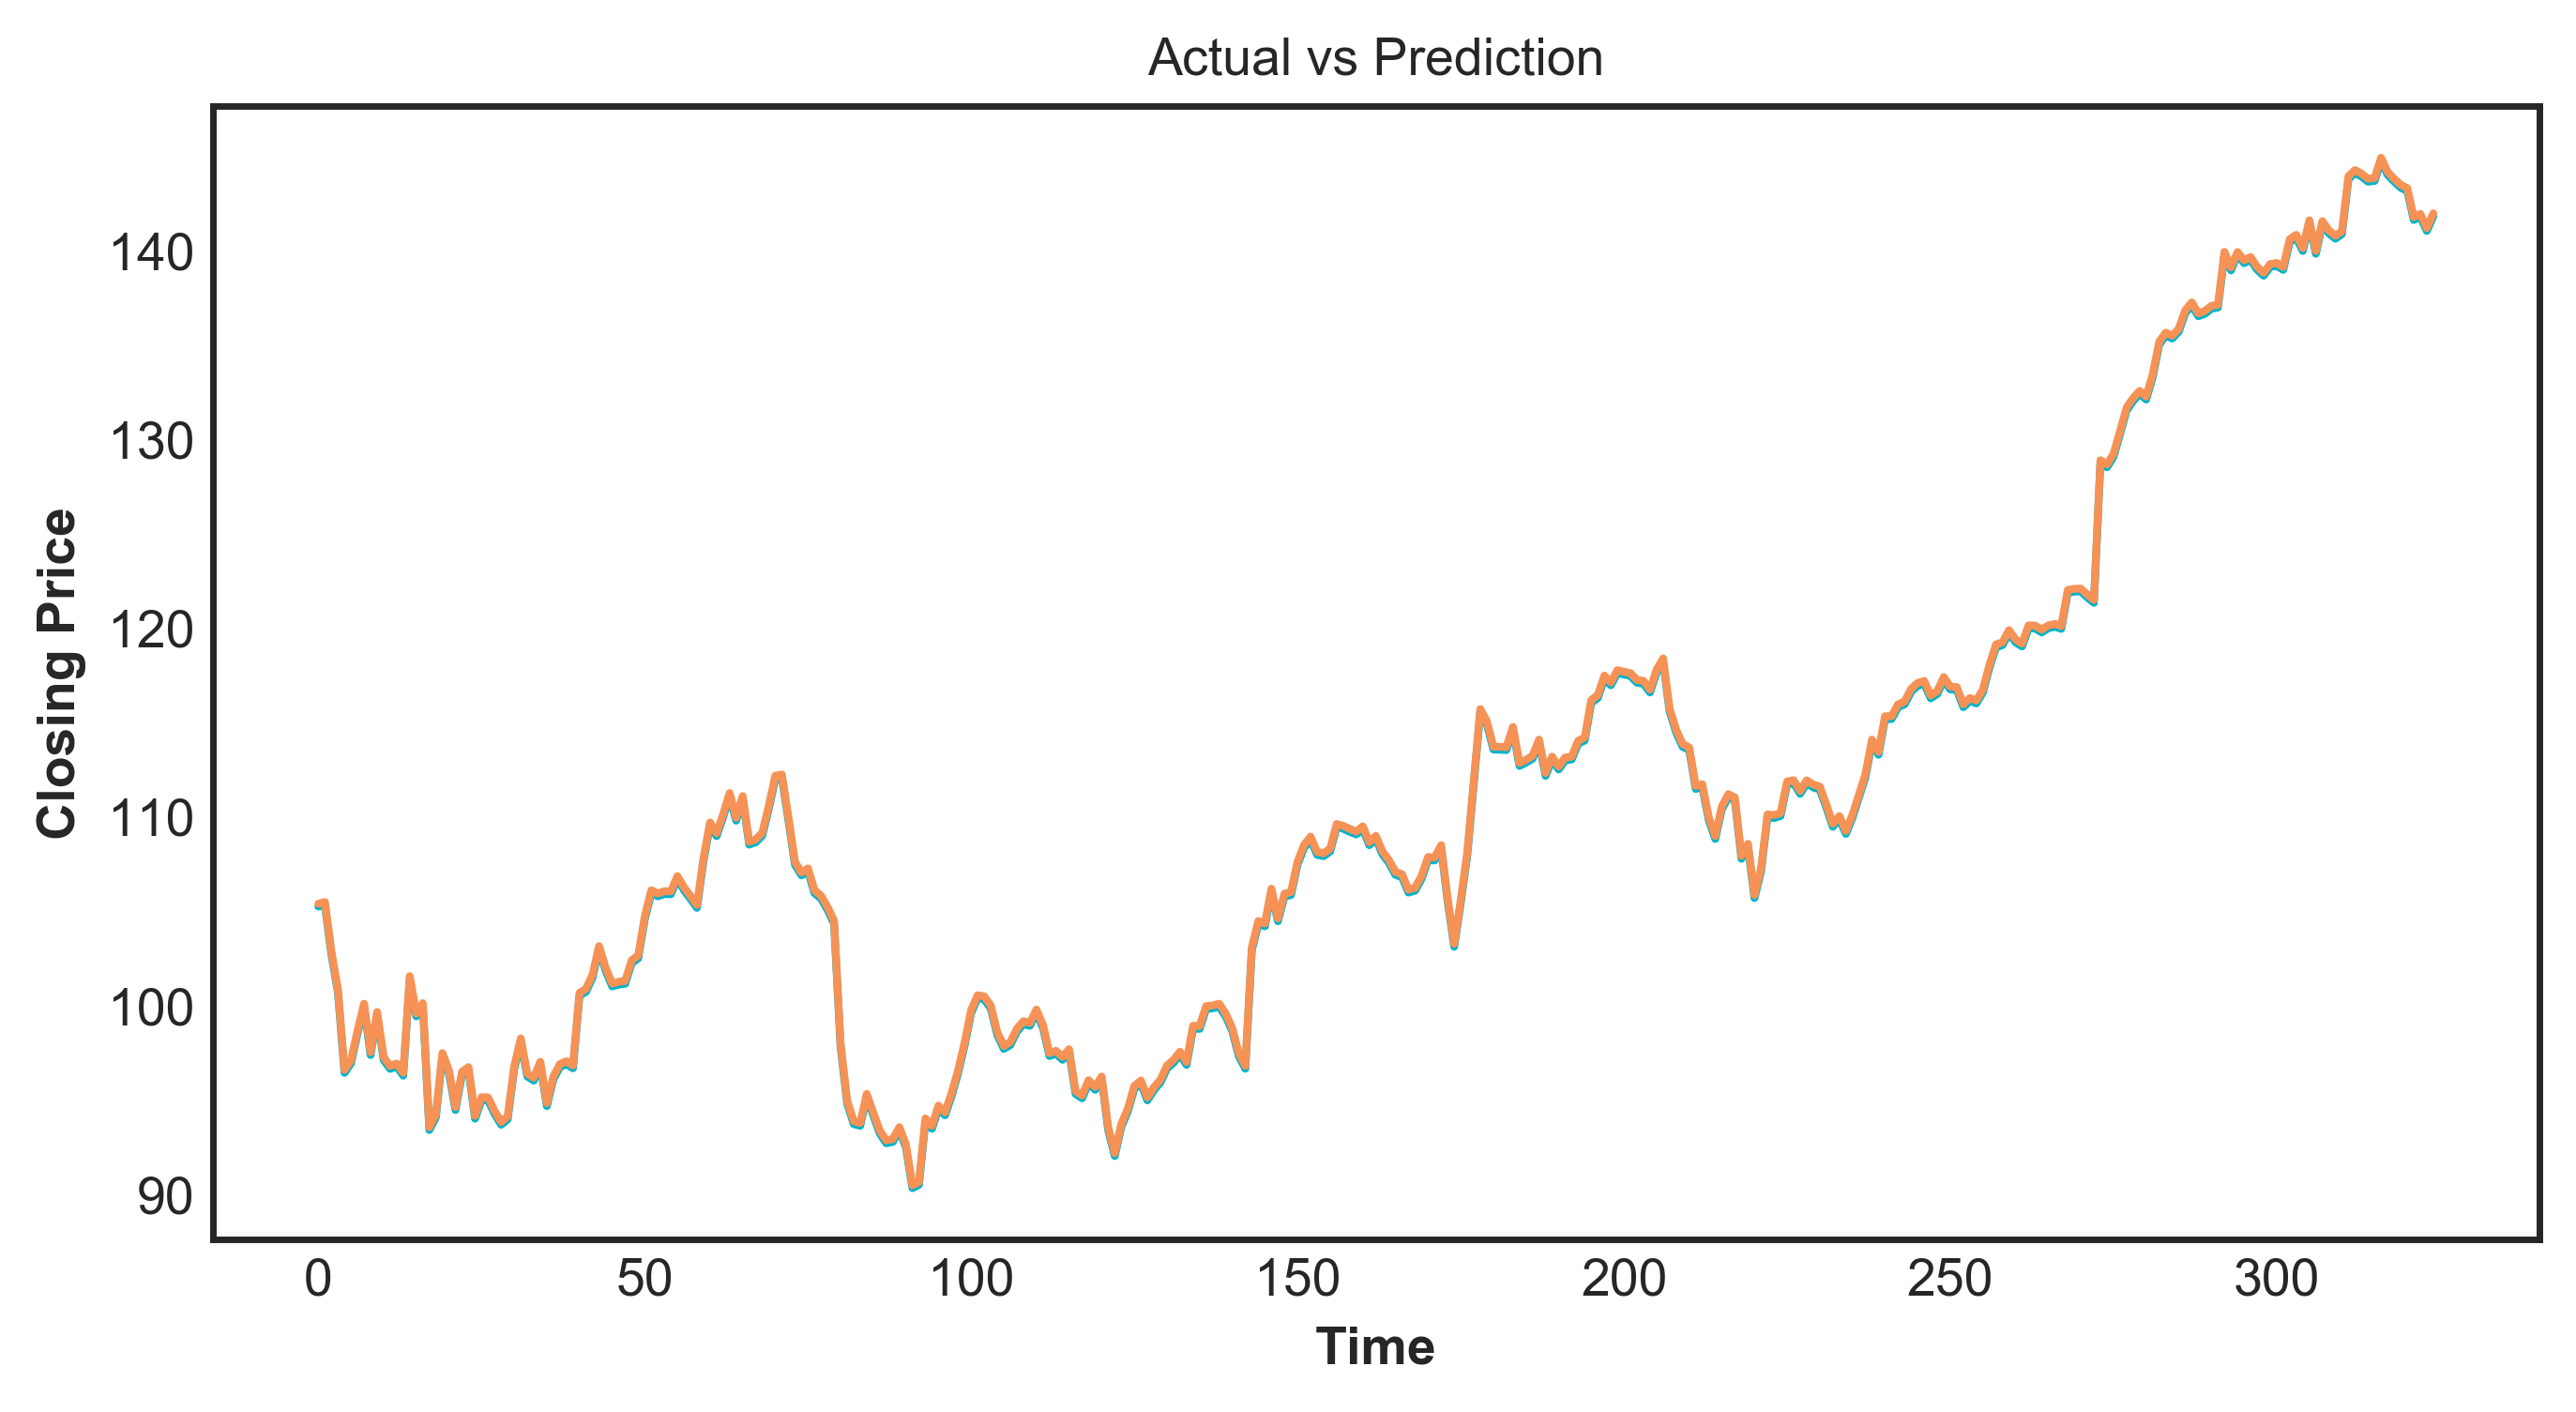

In [22]:
# training_predictions = np.concatenate((np.full((num_lags, 1), training_predictions[0]), training_predictions))
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.4)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction')
plt.plot(stocks[0].iloc[:training_size, :].values, color = "#00b3ca", label='Actual')
plt.plot(training_predictions, color = "#f69256", label='Prediction')
plt.show()

## Test Outcome

In [26]:
test_predictions = new_model.predict(test_input, batch_size=new_batch_size)
test_predictions = scalers[0].inverse_transform(test_predictions)

for i in range(training_size, len(df)+1):
    test_predictions[i-training_size][0] += stocks[0].iloc[i:i+1,:].values[0][0]

rmse = sqrt(mean_squared_error(stocks[0].iloc[training_size+1:, :].values, test_predictions[:-1]))
print('Test RMSE: %.4f' % rmse+' (%.4f' % (rmse/test_predictions[-1][0]*100) +'%)')

Test RMSE: 1.8871 (1.0930%)


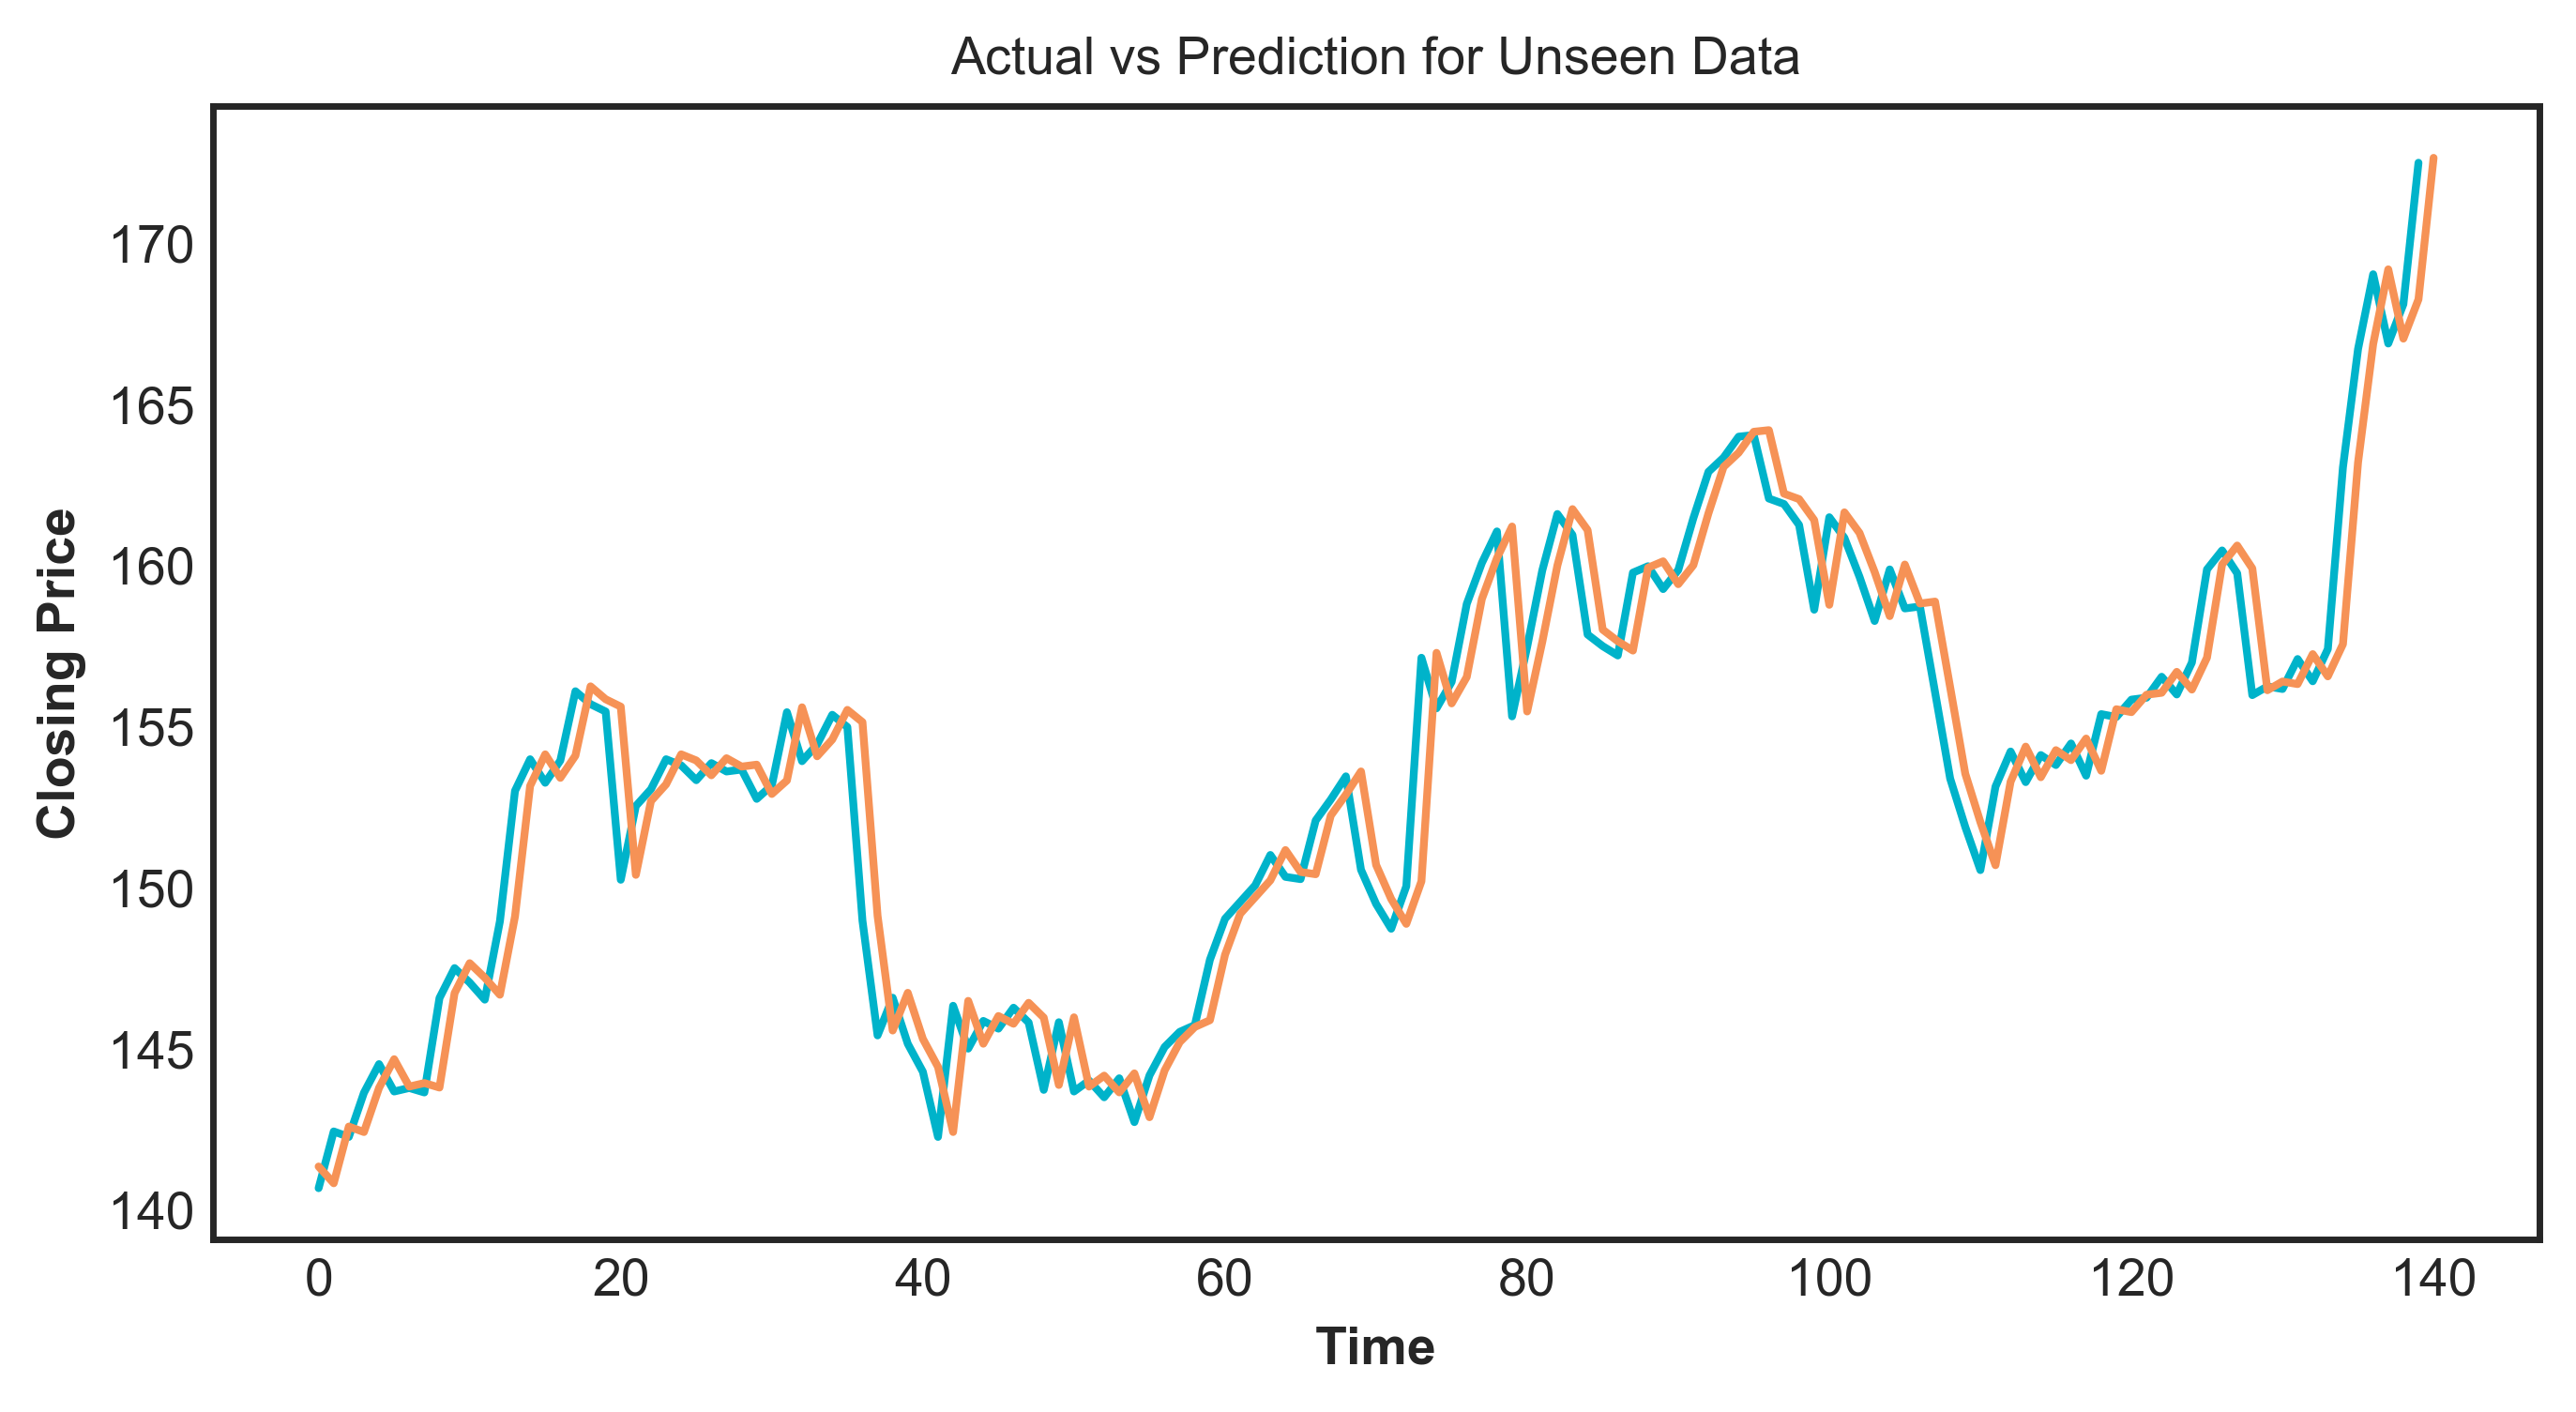

In [24]:
# test_predictions = np.concatenate((np.full((num_lags, 1), test_predictions[0]), test_predictions))
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.4)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.plot(stocks[0].iloc[training_size+1:, :].values, color = "#00b3ca",label='Actual')
plt.plot(test_predictions, color = "#f69256", label='Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction for Unseen Data')
plt.show()

## Forecasted Price

3/11/2017 is the day we bought the stocks, while 6/11/2017 is the day after the weekend where we predict a rise in price.

In [25]:
print("Closing Price 3/11/2017")
print(stocks[0].iloc[-1:,:1].values[0][0])
print('\n')
print("Predicted Closing Price on 6/11/2017")
print(test_predictions[-1][0])

Closing Price 3/11/2017
172.5


Predicted Closing Price on 6/11/2017
172.652
